In [31]:
local_path = '../'

"""## Prepare fastai"""
from fastai import *
from fastai.text import *
from fastai.metrics import *
torch.cuda.set_device(3)
np.random.seed(0)
"""## Prepare Dataset"""
local_project_path = local_path + 'data/proteinnet/'
if not os.path.exists(local_project_path):
    os.makedirs(local_project_path)
print('local_project_path:', local_project_path)

"""## Create Language Model"""
class dna_tokenizer(BaseTokenizer):
    def tokenizer(self, t):
        res = []
        tokens = t.split(' ')
        before_seq = tokens[:-2]
        seq = tokens[-2]
        eos = tokens[-1]
        
        res = before_seq
        res += list(seq) # sequence string to list
        res.append(eos)
        
        return res
tokenizer = Tokenizer(tok_func=dna_tokenizer, pre_rules=[], post_rules=[], special_cases=[])
processor = [TokenizeProcessor(tokenizer=tokenizer, include_bos= True, include_eos=True), NumericalizeProcessor(max_vocab=30000)]

local_project_path: ../data/proteinnet/


In [32]:
# batch size
bs = 512
data_lm = TextLMDataBunch.from_csv(local_project_path, 'test.csv',
                                   text_cols ='seq', valid_pct= 0.1, tokenizer=tokenizer,
                                   include_bos= True, include_eos=True, bs=bs)
print('data_cls Training set size', len(data_lm.train_ds))
print('data_cls Validation set size', len(data_lm.valid_ds))

data_cls Training set size 99908
data_cls Validation set size 11101


In [33]:
data_lm.show_batch()

idx,text
0,N N N N K T Y N N N N S N N S Y N N N N Y N N N S F N N N N N N N Y N N N N S N N N N N S N N N N L N K K P T F L E K K I Q Q E Q K Q K E L
1,K R D L V E P M S Q P S P S H G H E S N S E D S S L S D G D R T L V E T D N M A H R G G G D S Q V S S T S H S P Q L S S P E D E A A S H D A
2,L E N S E A D V K E S R K D V L P G A E G P A S G E G H A G N L A R C S E L T Q S Q A S L Q S A S S V G S A R G D E G A G Y T D V Y G D Y R
3,I D G K K L T E I I N E T H E N V K Y L K G H K L P T N V V A V P D L V E A A K N A D I L I F V V P H Q F I P N F C K Q L L G K I K P N A I
4,E L P I P E E P K K V V E P E K K P E E P K K P A Y A G L P V D D S S N S W M D V L D E P M N F S D D E E E P V P E P V K E E T L V E E V V


In [34]:
len(data_lm.vocab.itos)

40

In [35]:
len(data_lm.train_ds)

99908

In [36]:
data_lm.train_ds.x[0].text

'xxbos M A D E D D G L Q L N I C Y L Q R V P K K E I N S K A E E E A Y F K E N I S N N N N F T N N R A Y R E K T N K N E N N L N N N K N N N N N N N N N K T Y N N N N S N N S Y N N N N Y N N N S F N N N N N N N Y N N N N S N N N N N S N N N N L N K K P T F L E K K I Q Q E Q K Q K E L K E L K G P Q H H R Y R N Q E N E E S N A I E S N S N N F K D K Y K F A E N K T K K D E F N R P I L E T I E S N I K V E K S E T F S S M N W G S L Q L S E T L V R N L V G H M K H E K P T H I Q E A S I T P I L K G N D A L V K A Q T G S G K T L S Y L I P V V Q K L T E Q R V T R S D G C Y C V I I T P T R E L S S Q I Y E E L Q K L L K P F Y W I V P G I I M G G E N R S A E K A R I R K G I N I L V A T P G R L L D H L Q N T Q S F P T D N I K W C I L D E A D K L L D L G F E K D V T T I I N L L D S K K R T M K F K R Q N I L V S A T L S E G I S R L A S L S L T S P V Y I G L D S K V L E K G E N P F Q A A E K E M L Q A P K Q L D Q F Y V E V E S K E R L T S L I A F I R W K T S N I T I D K G D V A S G N S S A N S K M I V

In [37]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1, wd = 0.1, pretrained=False).to_fp16()

In [7]:
learn_lm.unfreeze()

In [8]:
lr = 3e-3
# lr *= bs/48
lr

0.003

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


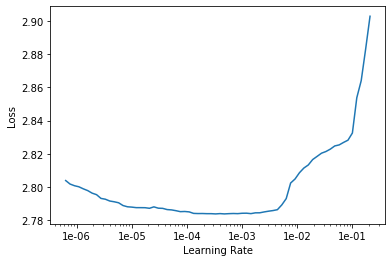

In [16]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end = 15)

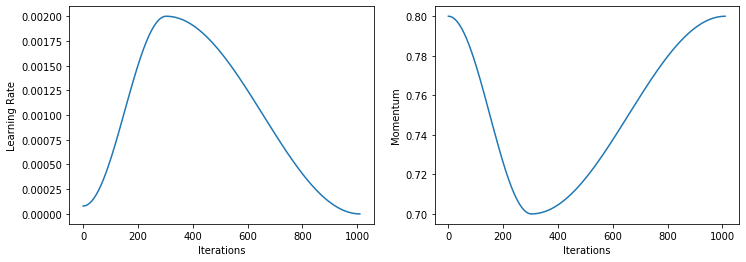

In [19]:
learn_lm.recorder.plot_lr(show_moms=True)

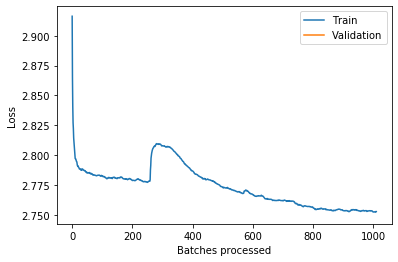

In [18]:
learn_lm.recorder.plot_losses()

In [9]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 512

epoch,train_loss,valid_loss,accuracy,time
0,2.812211,2.810705,0.130542,02:07


In [ ]:
lr = 1e-3
learn_lm.fit_one_cycle(20, lr, moms=(0.9,0.7)) #bs = 512

epoch,train_loss,valid_loss,accuracy,time
0,2.256884,2.358292,0.276891,02:07
1,2.258441,2.366593,0.274275,02:08
2,2.298977,2.383893,0.267791,02:08
3,2.328765,2.399047,0.264016,02:09
4,2.335975,2.406446,0.260732,02:09
5,2.351164,2.414245,0.258080,02:08
6,2.343598,2.396566,0.263705,02:09
7,2.318472,2.389632,0.266146,02:06
8,2.304443,2.380130,0.268817,02:08
9,2.296807,2.373126,0.270973,02:05


In [27]:
lr = 9e-4
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 512

epoch,train_loss,valid_loss,accuracy,time
0,2.064945,2.266142,0.306952,02:02


In [ ]:
learn_lm.save('lm-gpu3-sp-40M-v1');

In [38]:
learn_lm.load('lm-gpu3-sp-40M-v2');

In [39]:
learn_lm.save_encoder('lm-gpu3-sp-40M-v2-enc');

In [20]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 128

epoch,train_loss,valid_loss,accuracy,time
0,2.621008,2.605378,0.195324,03:39


In [16]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 2048

epoch,train_loss,valid_loss,accuracy,time
0,2.800748,2.787503,0.140276,01:53


In [11]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 2048, lr *=

epoch,train_loss,valid_loss,accuracy,time
0,3.011955,3.005413,0.095623,01:49


In [7]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7)) #bs = 512, lr *=

epoch,train_loss,valid_loss,accuracy,time
0,3.006657,3.003952,0.095272,02:03


In [40]:
learn_lm.validate(metrics=[accuracy])

[2.4292638, tensor(0.2818)]

In [13]:
learn_lm.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 40]             16,040     True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 16,040
Total trainable params: 16,040
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function :